In [ ]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tabulate import tabulate

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [1]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

In [ ]:
threshold = 0.5
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-12"
test_predictions_list, test_labels_list = [], []
train_predictions_list, train_labels_list = [], []

# Initialize lists to store results for display results
results = []

print(f"Classifier model date: {model_date}")

for kmer in kmer_values:

    args.model_path = f"./outputs/classifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_test.txt"
    args.train_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_train.txt"

    # Load training and testing datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training dataset
    train_predictions, train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    train_predictions_list.append(train_predictions)
    train_labels_list.append(train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(train_predictions, train_labels, threshold=threshold)
    results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    test_predictions, test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    test_predictions_list.append(test_predictions)
    test_labels_list.append(test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(test_predictions, test_labels, threshold=threshold)
    results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

In [ ]:
# Convert results to DataFrame for tabulation
results_df = pd.DataFrame(results, columns=["k-mer", "Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Split DataFrame into training and testing
training_df = results_df[results_df['Dataset'].str.contains("Train")]
testing_df = results_df[results_df['Dataset'].str.contains("Test")]

# Display results in tabulated format
print("Training Results:")
print(tabulate(training_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

print("\nTesting Results:")
print(tabulate(testing_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Training Results:
+---------+-----------+------------+---------------+---------------+--------+--------+
|   k-mer | Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+=========+===========+============+===============+===============+========+========+
|       3 | Train     |     0.9124 |        0.8787 |        0.9461 | 0.8267 | 0.9259 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       4 | Train     |     0.9205 |        0.8854 |        0.9555 | 0.8430 | 0.9186 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       5 | Train     |     0.8982 |        0.8329 |        0.9636 | 0.8034 | 0.8944 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       6 | Train     |     0.9043 |        0.8423 |        0.9663 | 0.8149 | 0.8987 |
+---------+-----------+------------+---------------+---------------+--------+--------+

Testing Results:
+------

In [ ]:
# Calculate averages for training predictions and labels
train_predictions_average = np.array(train_predictions_list).mean(axis=0)
train_labels_average = np.array(train_labels_list).mean(axis=0)
train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_average, train_labels_average, threshold=threshold)

# Calculate averages for test predictions and labels
test_predictions_average = np.array(test_predictions_list).mean(axis=0)
test_labels_average = np.array(test_labels_list).mean(axis=0)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_average, test_labels_average, threshold=threshold)

# Prepare data for table
ensemble_results = [
    ["Ensemble Training", f"{train_acc:.4f}", f"{train_sn:.4f}", f"{train_sp:.4f}", f"{train_mcc:.4f}", f"{train_auc:.4f}"],
    ["Ensemble Testing", f"{test_acc:.4f}", f"{test_sn:.4f}", f"{test_sp:.4f}", f"{test_mcc:.4f}", f"{test_auc:.4f}"]
]
ensemble_results_df = pd.DataFrame(ensemble_results, columns=["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Display results in a tabulated format
print(f"Threshold = {threshold}")
print(tabulate(ensemble_results_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Threshold = 0.5
+-------------------+------------+---------------+---------------+--------+--------+
| Dataset           |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===================+============+===============+===============+========+========+
| Ensemble Training |     0.9313 |        0.8841 |        0.9784 | 0.8664 | 0.9729 |
+-------------------+------------+---------------+---------------+--------+--------+
| Ensemble Testing  |     0.8800 |        0.8600 |        0.9000 | 0.7606 | 0.9494 |
+-------------------+------------+---------------+---------------+--------+--------+


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

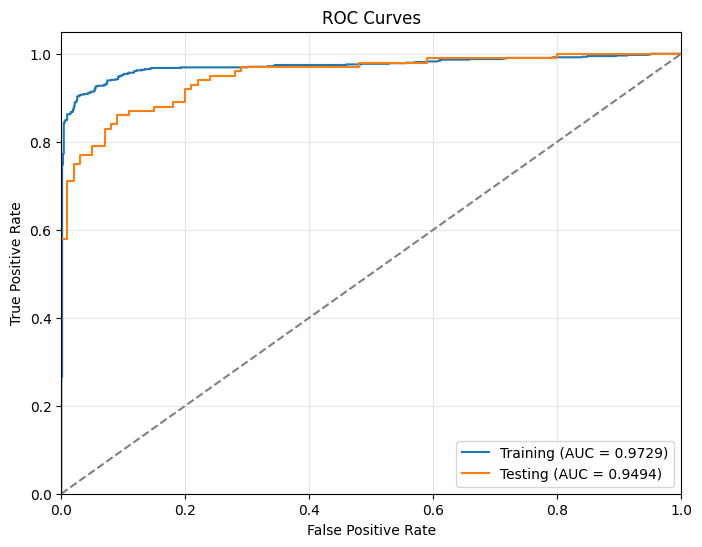

In [ ]:
# Function to plot ROC curve
def plot_single_roc_curve(predictions, labels, dataset_name):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.4f})')

# Plot ROC curves for training and testing datasets
plt.figure(figsize=(8, 6))

# Training ROC Curve
plot_single_roc_curve(train_predictions_average, train_labels_average, "Training")

# Testing ROC Curve
plot_single_roc_curve(test_predictions_average, test_labels_average, "Testing")

# Plot settings
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

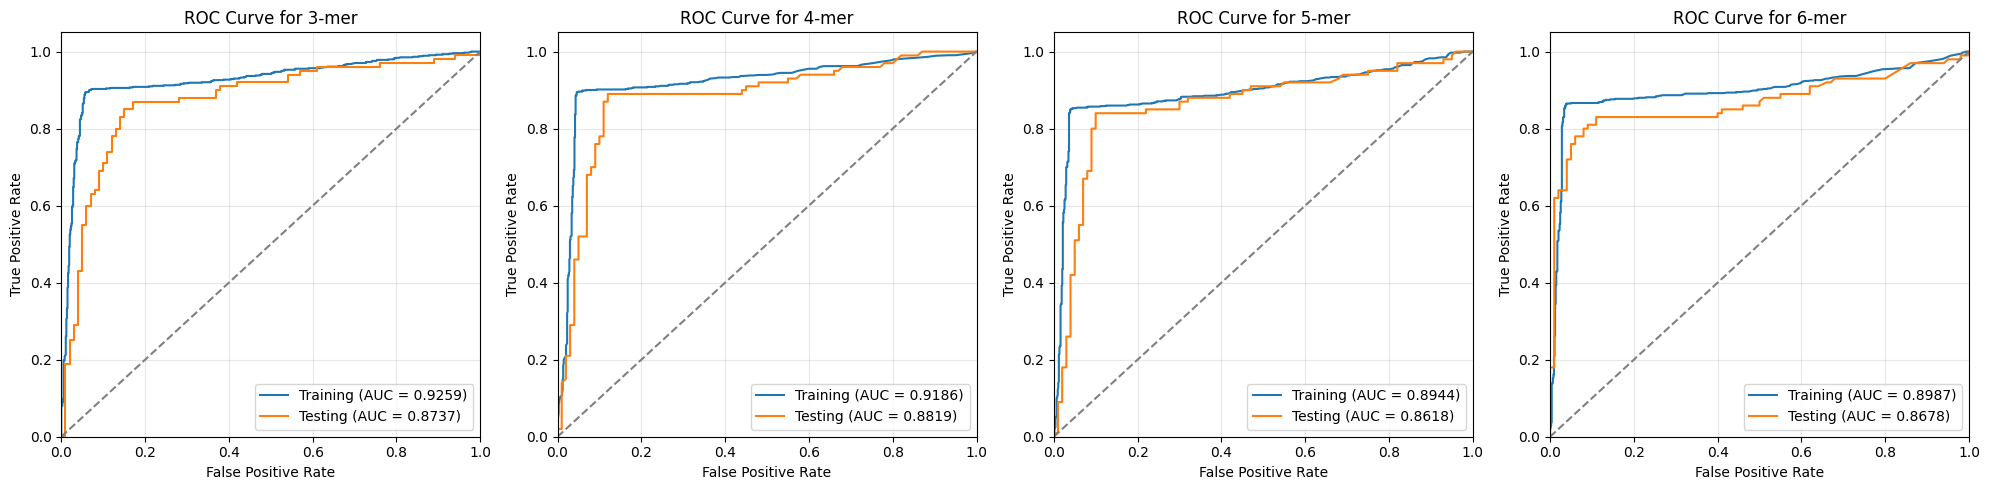

In [ ]:
def plot_roc_curve(ax, predictions_train, labels_train, predictions_test, labels_test, k):
    fpr_train, tpr_train, _ = roc_curve(labels_train, predictions_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, label=f'Training (AUC = {roc_auc_train:.4f})')
    
    fpr_test, tpr_test, _ = roc_curve(labels_test, predictions_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax.plot(fpr_test, tpr_test, label=f'Testing (AUC = {roc_auc_test:.4f})')
    
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {k}-mer')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

num_kkmer_values = len(kmer_values)
cols = 4
rows = (num_kkmer_values + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, mer in enumerate(kmer_values):
    train_predictions = train_predictions_list[i]
    train_labels = train_labels_list[i]
    test_predictions = test_predictions_list[i]
    test_labels = test_labels_list[i]
    
    plot_roc_curve(axes[i], train_predictions, train_labels, test_predictions, test_labels, mer)

for j in range(num_kkmer_values, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

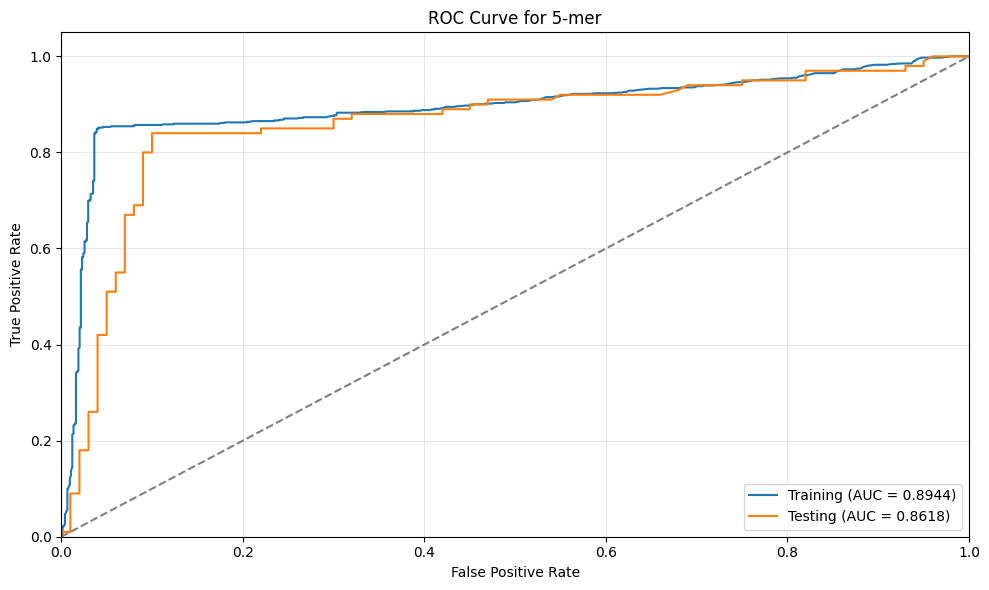

In [ ]:
def plot_roc_curve(ax, predictions_train, labels_train, predictions_test, labels_test, k):
    fpr_train, tpr_train, _ = roc_curve(labels_train, predictions_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, label=f'Training (AUC = {roc_auc_train:.4f})')
    
    fpr_test, tpr_test, _ = roc_curve(labels_test, predictions_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    ax.plot(fpr_test, tpr_test, label=f'Testing (AUC = {roc_auc_test:.4f})')
    
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {k}-mer')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

k = 5

fig, ax = plt.subplots(figsize=(10, 6))

train_predictions = train_predictions_list[kmer_values.index(k)]
train_labels = train_labels_list[kmer_values.index(k)]
test_predictions = test_predictions_list[kmer_values.index(k)]
test_labels = test_labels_list[kmer_values.index(k)]

plot_roc_curve(ax, train_predictions, train_labels, test_predictions, test_labels, k)

plt.tight_layout()
plt.show()


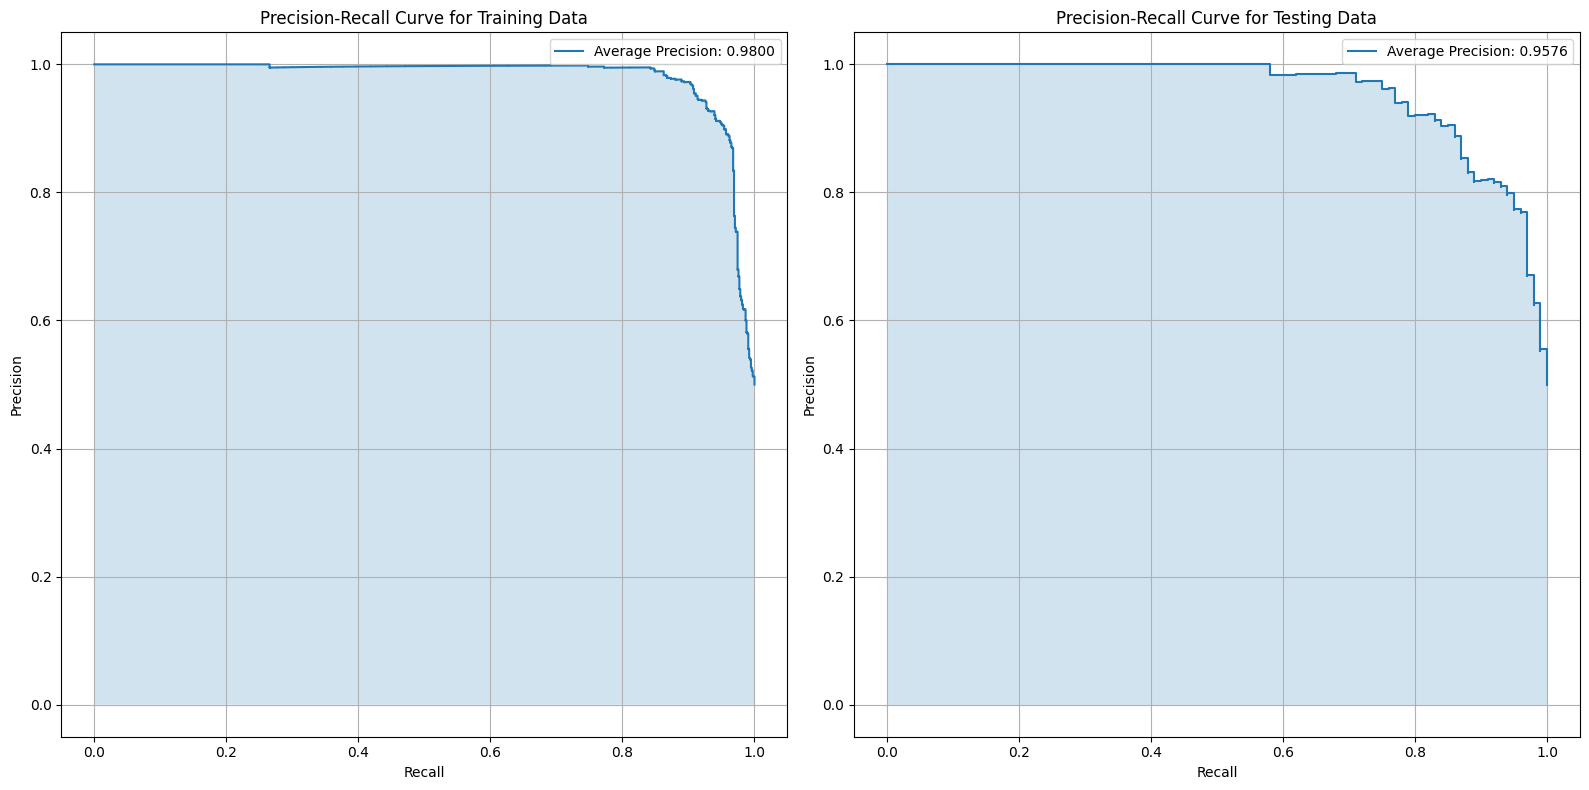

In [ ]:
# Calculate precision and recall for training data
precision_train, recall_train, _ = precision_recall_curve(train_labels_average, train_predictions_average)
average_precision_train = average_precision_score(train_labels_average, train_predictions_average)

# Calculate precision and recall for test data
precision_test, recall_test, _ = precision_recall_curve(test_labels_average, test_predictions_average)
average_precision_test = average_precision_score(test_labels_average, test_predictions_average)

# Plotting the PR curves in subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Training PR curve
axs[0].step(recall_train, precision_train, where='post', label=f'Average Precision: {average_precision_train:.4f}')
axs[0].fill_between(recall_train, precision_train, step='post', alpha=0.2)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve for Training Data')
axs[0].legend(loc='best')
axs[0].grid(True)

# Testing PR curve
axs[1].step(recall_test, precision_test, where='post', label=f'Average Precision: {average_precision_test:.4f}')
axs[1].fill_between(recall_test, precision_test, step='post', alpha=0.2)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve for Testing Data')
axs[1].legend(loc='best')
axs[1].grid(True)

plt.tight_layout()
plt.show()

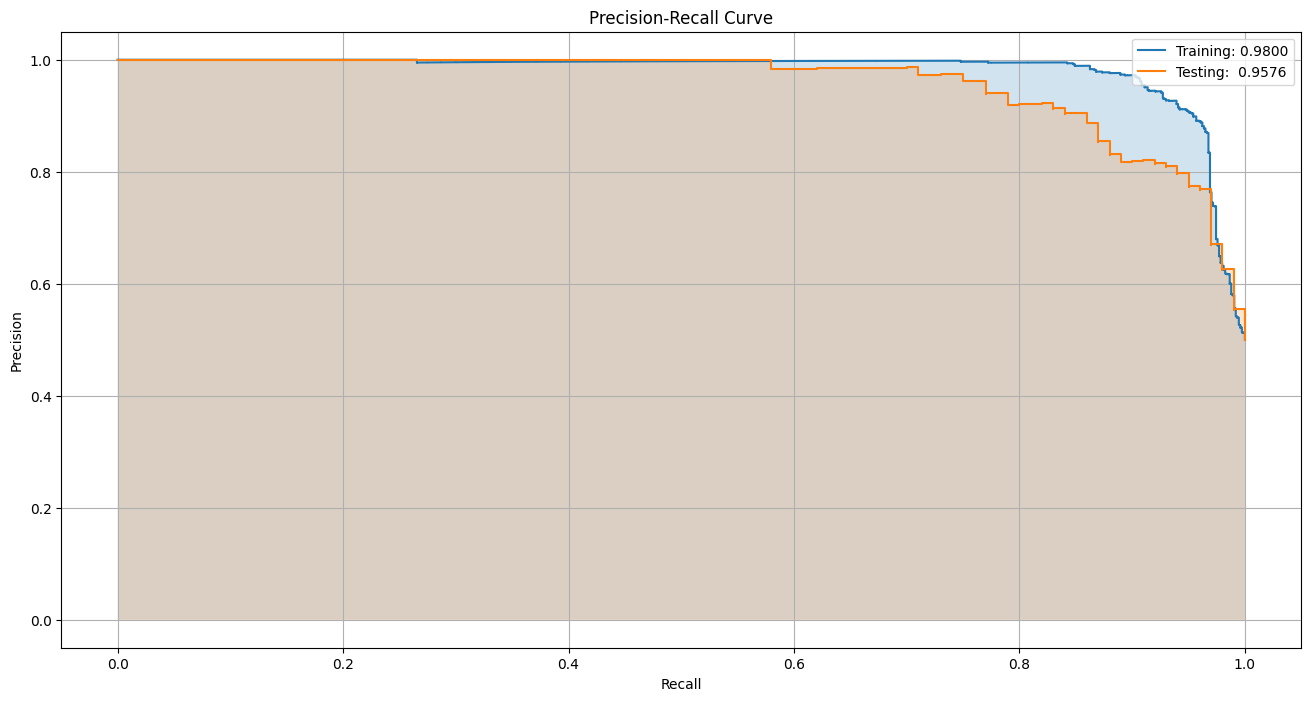

In [ ]:

# Calculate precision and recall for training data
precision_train, recall_train, _ = precision_recall_curve(train_labels_average, train_predictions_average)
average_precision_train = average_precision_score(train_labels_average, train_predictions_average)

# Calculate precision and recall for test data
precision_test, recall_test, _ = precision_recall_curve(test_labels_average, test_predictions_average)
average_precision_test = average_precision_score(test_labels_average, test_predictions_average)

# Plotting the PR curves
plt.figure(figsize=(16, 8))

# Training PR curve
plt.step(recall_train, precision_train, where='post', label=f'Training: {average_precision_train:.4f}')
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2)

# Test PR curve
plt.step(recall_test, precision_test, where='post', label=f'Testing:  {average_precision_test:.4f}')
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2)

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

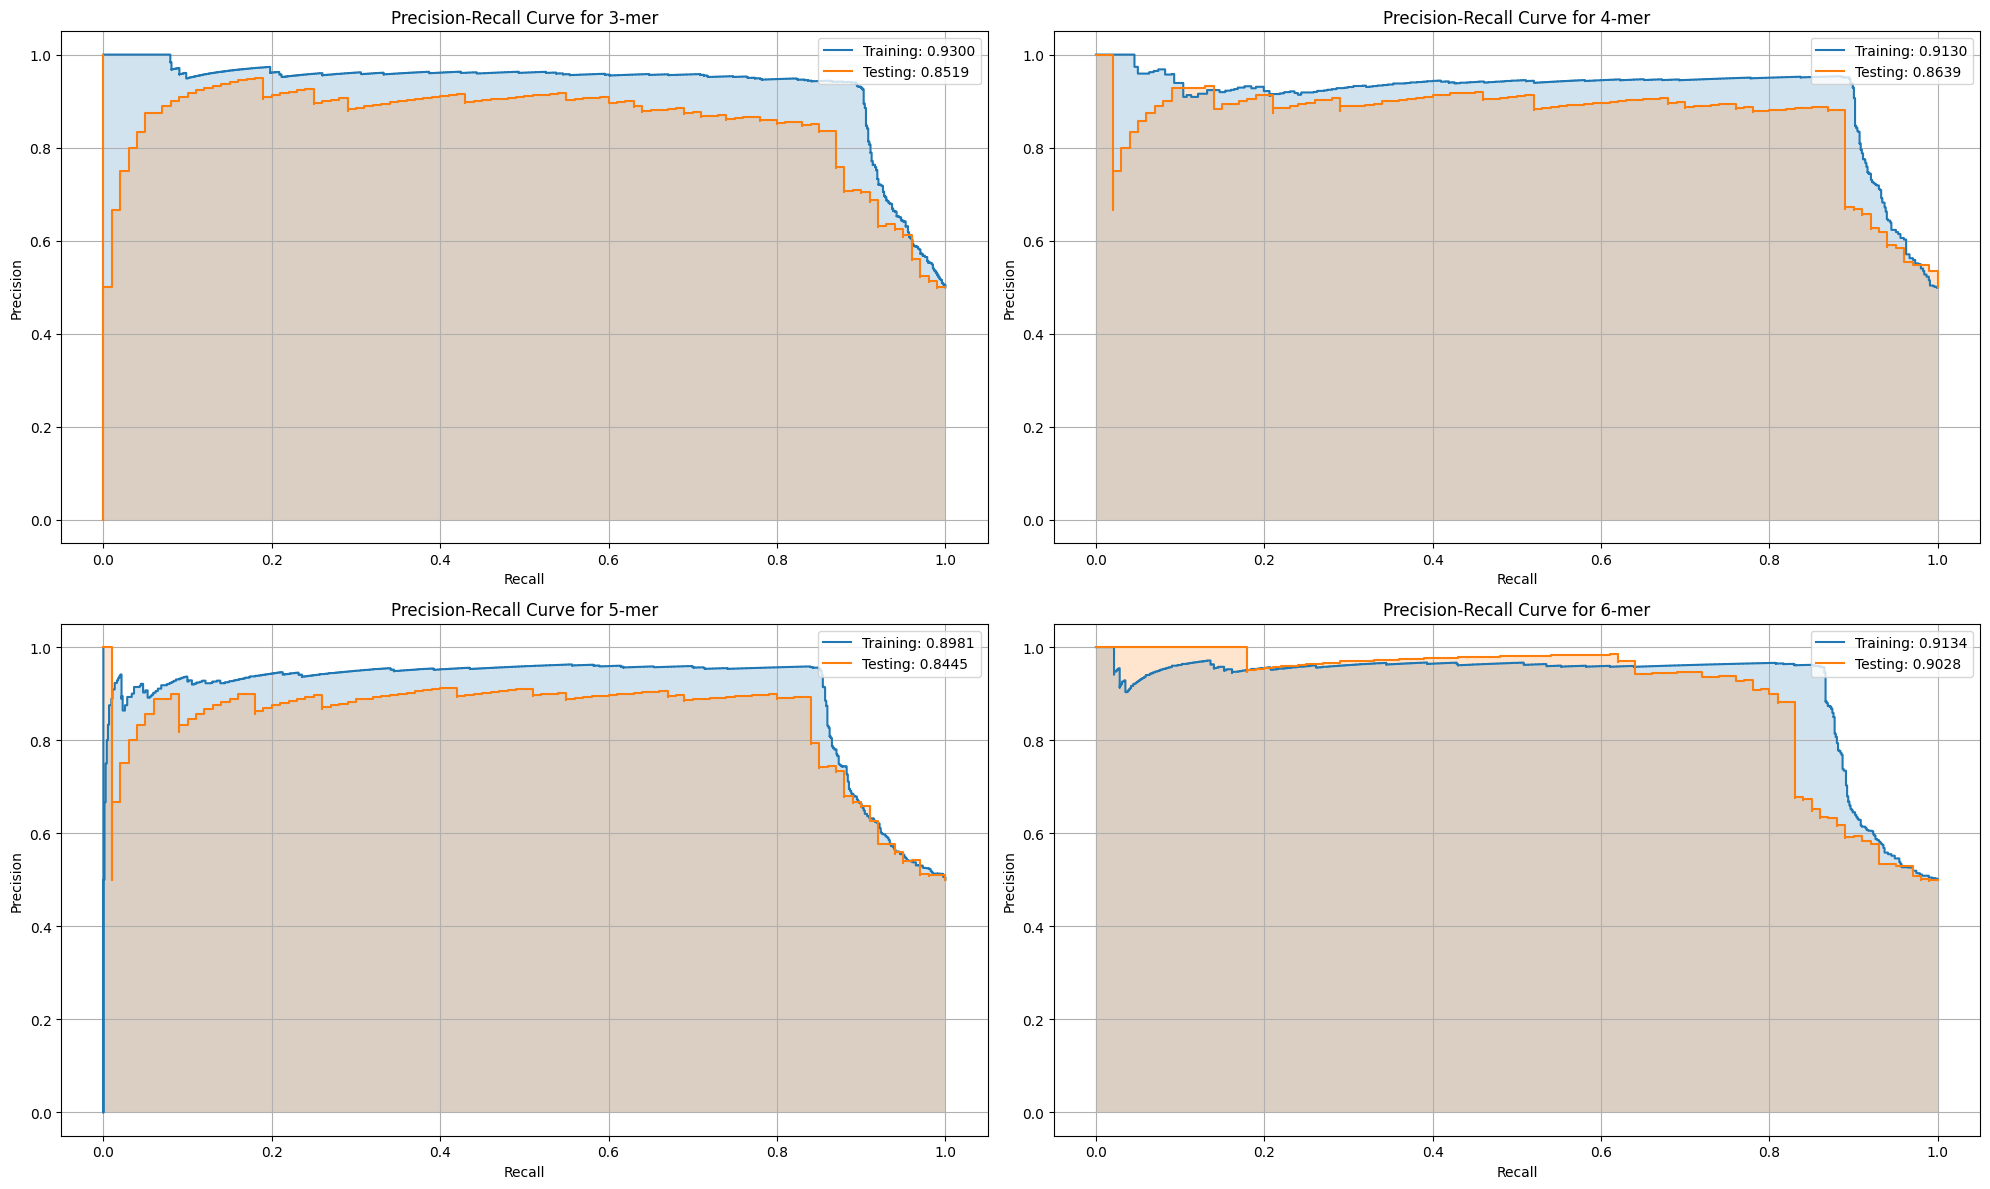

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # Create a figure with 2 rows and 2 columns

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data for the current k-mer
    precision_train, recall_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_train = average_precision_score(train_labels_list[i], train_predictions_list[i])

    # Calculate precision and recall for test data for the current k-mer
    precision_test, recall_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_test = average_precision_score(test_labels_list[i], test_predictions_list[i])

    # Determine the position of the subplot
    ax = axs[i // 2, i % 2]

    # Training PR curve
    ax.step(recall_train, precision_train, where='post', label=f'Training: {average_precision_train:.4f}')
    ax.fill_between(recall_train, precision_train, step='post', alpha=0.2)
    ax.step(recall_test, precision_test, where='post', label=f'Testing: {average_precision_test:.4f}')
    ax.fill_between(recall_test, precision_test, step='post', alpha=0.2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {mer}-mer')
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()

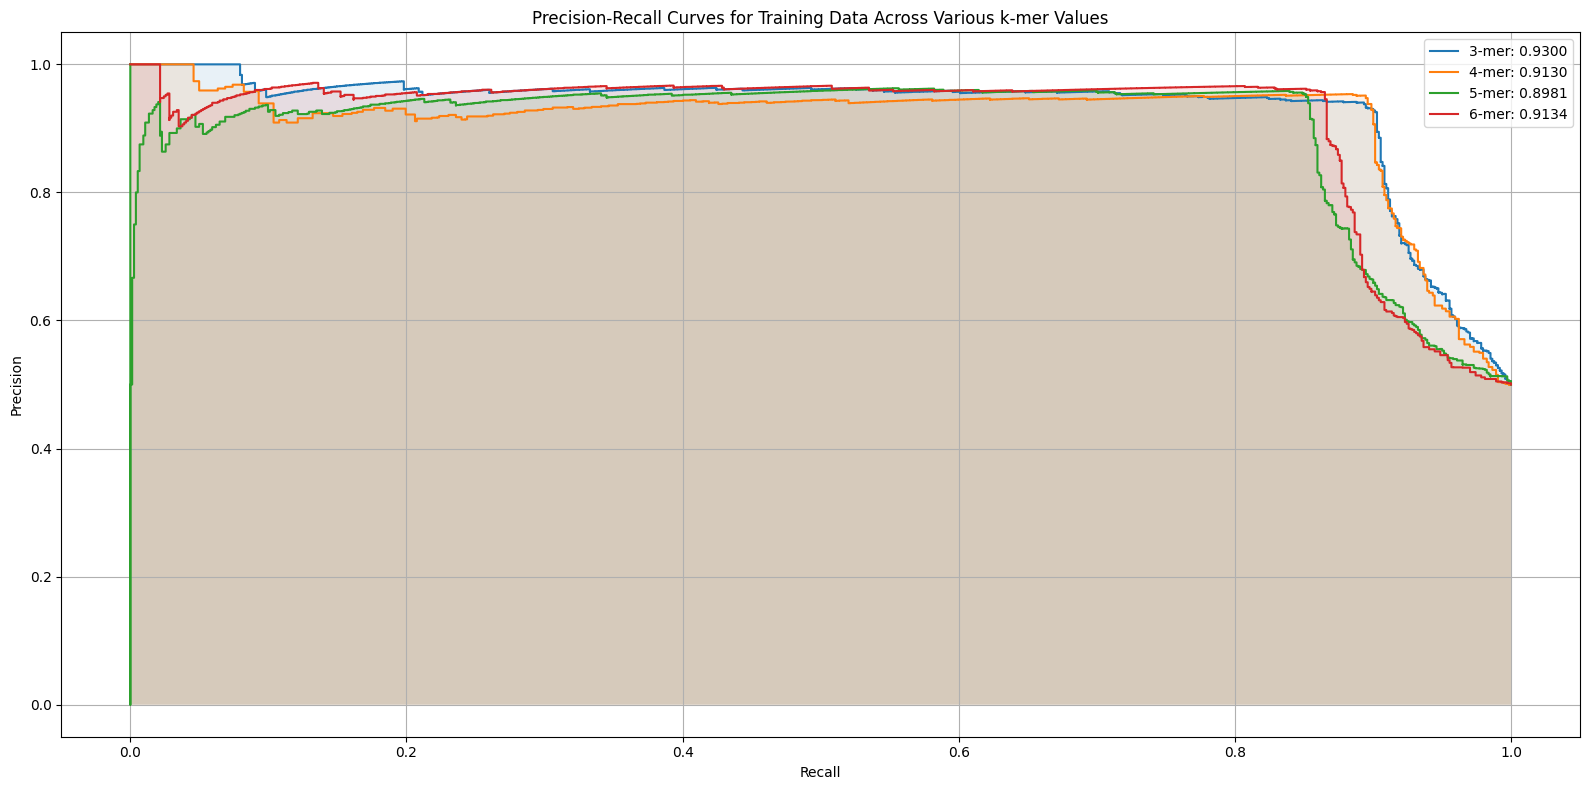

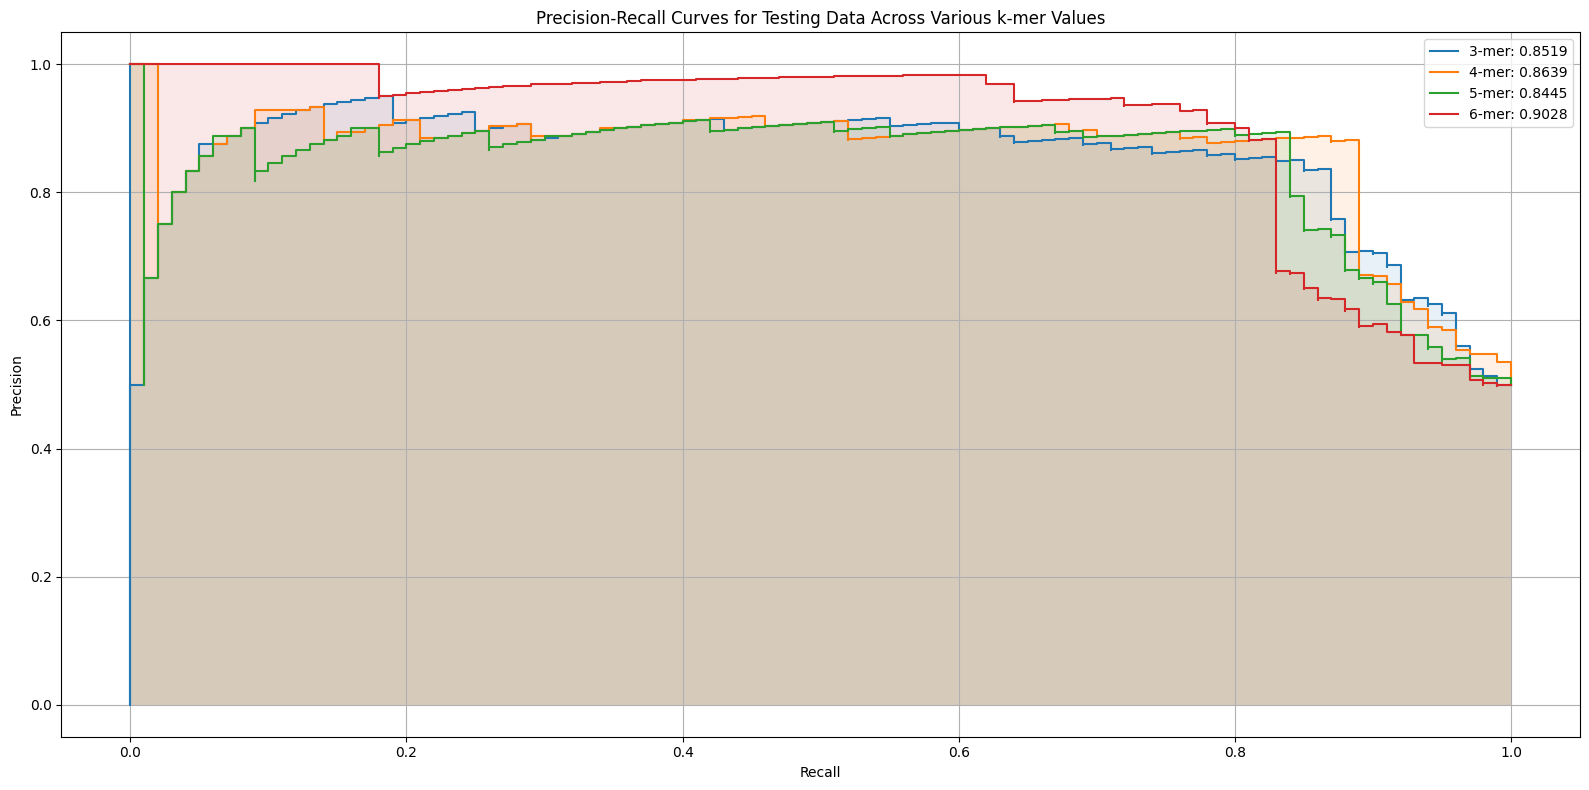

: 

In [ ]:
# Plot for Training Data
plt.figure(figsize=(16, 8))

for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for training data
    precision_train, recall_train, _ = precision_recall_curve(train_labels_list[i], train_predictions_list[i])
    average_precision_train = average_precision_score(train_labels_list[i], train_predictions_list[i])

    # Add the PR curve to the training plot
    plt.step(recall_train, precision_train, where='post', label=f'{mer}-mer: {average_precision_train:.4f}')
    plt.fill_between(recall_train, precision_train, step='post', alpha=0.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Training Data Across Various k-mer Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Testing Data
plt.figure(figsize=(16, 8)) 
for i, mer in enumerate(kmer_values):
    # Calculate precision and recall for test data
    precision_test, recall_test, _ = precision_recall_curve(test_labels_list[i], test_predictions_list[i])
    average_precision_test = average_precision_score(test_labels_list[i], test_predictions_list[i])

    # Add the PR curve to the testing plot
    plt.step(recall_test, precision_test, where='post', label=f'{mer}-mer: {average_precision_test:.4f}')
    plt.fill_between(recall_test, precision_test, step='post', alpha=0.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Testing Data Across Various k-mer Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
